In [1]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

In [2]:
datafile = './mnist.json.gz'
print('loading mnist dataset from {} ......'.format(datafile))
data = json.load(gzip.open(datafile))
print('mnist dataset load done')
train_set, val_set, eval_set = data
imgs, labels = train_set[0], train_set[1]
print("训练数据集数量: ", len(imgs))
imgs, labels = val_set[0], val_set[1]
print("验证数据集数量: ", len(imgs))
imgs, labels = val= eval_set[0], eval_set[1]
print("测试数据集数量: ", len(imgs))
print(len(imgs[0]))

loading mnist dataset from ./mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000
验证数据集数量:  10000
测试数据集数量:  10000
784


In [3]:
imgs, labels = train_set[0], train_set[1]
print("训练数据集数量: ", len(imgs))
imgs_length = len(imgs)
index_list = list(range(imgs_length))
BATCHSIZE = 100
random.shuffle(index_list)
def data_generator():
    imgs_list = []
    labels_list = []
    for i in index_list:
        img = np.array(imgs[i]).astype('float32')
        label = np.array(labels[i]).astype('float32')
        imgs_list.append(img) 
        labels_list.append(label)
        if len(imgs_list) == BATCHSIZE:
            yield np.array(imgs_list), np.array(labels_list)
            imgs_list = []
            labels_list = []
    if len(imgs_list) > 0:
        yield np.array(imgs_list), np.array(labels_list)
    return data_generator

训练数据集数量:  50000


In [4]:
train_loader = data_generator
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    if batch_id == 0:
        print("打印第一个batch数据的维度:")
        print("图像维度: {}, 标签维度: {}".format(image_data.shape, label_data.shape))
    break

打印第一个batch数据的维度:
图像维度: (100, 784), 标签维度: (100,)


In [5]:
imgs_length = len(imgs)

assert len(imgs) == len(labels), \
        "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(label))

In [6]:
train_loader = data_generator
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    if batch_id == 0:
        print("打印第一个batch数据的维度，以及数据的类型:")
        print("图像维度: {}, 标签维度: {}, 图像数据类型: {}, 标签数据类型: {}".format(image_data.shape, label_data.shape, type(image_data), type(label_data)))
    break

打印第一个batch数据的维度，以及数据的类型:
图像维度: (100, 784), 标签维度: (100,), 图像数据类型: <class 'numpy.ndarray'>, 标签数据类型: <class 'numpy.ndarray'>


In [9]:
def load_data(mode='train'):
    datafile = './mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')
    train_set, val_set, eval_set = data
    if mode=='train':
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        imgs, labels = val_set[0], val_set[1]
    elif mode=='eval':
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")
    print("训练数据集数量: ", len(imgs))
    imgs_length = len(imgs)
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
    imgs_length = len(imgs)
    index_list = list(range(imgs_length))
    # 读入数据时用到的批次大小
    BATCHSIZE = 100
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [10]:
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs
def train(model):
    model = MNIST()
    model.train()
    train_loader = load_data('train')
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels) 
            predits = model(images)
            loss = F.square_error_cost(predits, labels)
            avg_loss = paddle.mean(loss)      
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    paddle.save(model.state_dict(), './mnist.pdparams')
model = MNIST()
train(model)

loading mnist dataset from ./mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000
epoch: 0, batch: 0, loss is: [23.204666]
epoch: 0, batch: 200, loss is: [9.131752]
epoch: 0, batch: 400, loss is: [9.934478]
epoch: 1, batch: 0, loss is: [8.644473]
epoch: 1, batch: 200, loss is: [8.279926]
epoch: 1, batch: 400, loss is: [8.898513]
epoch: 2, batch: 0, loss is: [8.476706]
epoch: 2, batch: 200, loss is: [8.941778]
epoch: 2, batch: 400, loss is: [7.0843186]
epoch: 3, batch: 0, loss is: [8.872118]
epoch: 3, batch: 200, loss is: [9.844625]
epoch: 3, batch: 400, loss is: [8.81365]
epoch: 4, batch: 0, loss is: [10.322013]
epoch: 4, batch: 200, loss is: [8.868123]
epoch: 4, batch: 400, loss is: [10.612151]
epoch: 5, batch: 0, loss is: [9.306203]
epoch: 5, batch: 200, loss is: [9.351167]
epoch: 5, batch: 400, loss is: [8.959129]
epoch: 6, batch: 0, loss is: [9.129116]
epoch: 6, batch: 200, loss is: [8.350331]
epoch: 6, batch: 400, loss is: [7.8182197]
epoch: 7, batch: 0, loss is: [8.280106

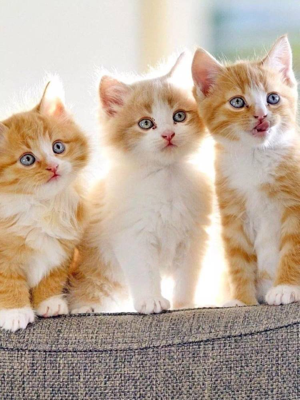

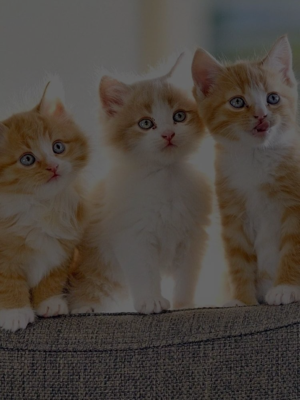

In [11]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import functional as F

img_path="./Image_1701217097634.jpg"
image=Image.open(img_path)

new_img=F.adjust_brightness(image,0.4)

display(image.resize((300,400)))
display(new_img.resize((300,400)))

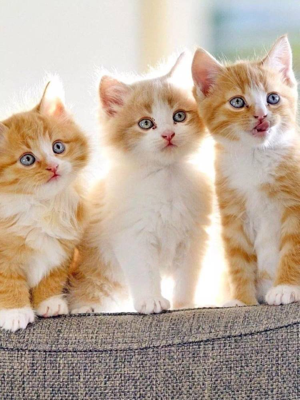

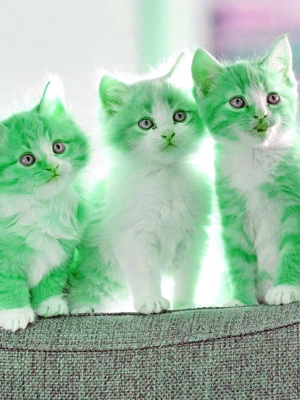

In [ ]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import functional as F

img_path="./Image_1701217097634.jpg"
image=Image.open(img_path)

new_img=F.adjust_hue(image,0.3)

display(image.resize((300,400)))
display(new_img.resize((300,400)))

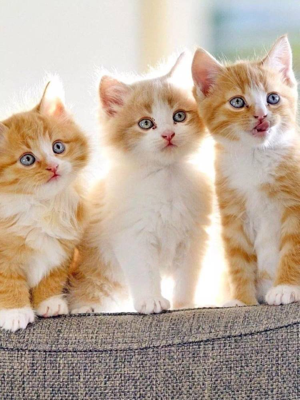

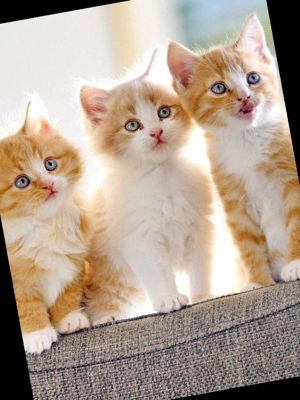

In [ ]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import RandomRotation

img_path="./Image_1701217097634.jpg"
image=Image.open(img_path)

transform = RandomRotation(90)

new_img=transform(image)

display(image.resize((300,400)))
display(new_img.resize((300,400)))